In [2]:
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.layers import Reshape, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
import numpy as np
import matplotlib.pyplot as plt

In [5]:
# load MNIST dataset
(x_train, _), (x_test, _) = mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [6]:
print("train data:",x_train.shape)
print("test data:",x_test.shape)

image_size = x_train.shape[1]
x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
x_test = np.reshape(x_test, [-1, image_size, image_size, 1])

train data: (60000, 28, 28)
test data: (10000, 28, 28)


In [7]:
print("train after reshape:",x_train.shape)
print("test after reshape:",x_test.shape)

train after reshape: (60000, 28, 28, 1)
test after reshape: (10000, 28, 28, 1)


In [8]:
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [9]:
# network parameters
input_shape = (image_size, image_size, 1)
batch_size = 32
kernel_size = 3
latent_dim = 16
# encoder/decoder number of CNN layers and filters per layer
layer_filters = [32, 64]

In [10]:
# build the autoencoder model
# first build the encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
# stack of Conv2D(32)-Conv2D(64)
for filters in layer_filters:
    x = Conv2D(filters=filters,
    kernel_size=kernel_size,
    activation='relu',
    strides=2,
    padding='same')(x)

In [11]:
shape = K.int_shape(x)
shape

(None, 7, 7, 64)

In [12]:
# generate latent vector
x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)
# instantiate encoder model
encoder = Model(inputs,
latent,
name='encoder')
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)           │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 14, 14, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 7, 7, 64)            │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 3136)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ latent_vector (Dense)                │ (None, 16)                  │          50,192 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 69,008 (269.56 KB)

 Trainable params: 69,008 (269.56 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# build the decoder model
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
# use the shape (7, 7, 64) that was earlier saved
x = Dense(shape[1] * shape[2] * shape[3])(latent_inputs)
# from vector to suitable shape for transposed conv
x = Reshape((shape[1], shape[2], shape[3]))(x)

In [15]:
for filters in layer_filters[::-1]:
            x = Conv2DTranspose(filters=filters, kernel_size=kernel_size,activation='relu',strides=2,  padding='same')(x)

In [16]:
outputs = Conv2DTranspose(filters=1,
                                    kernel_size=kernel_size,
                                    activation='sigmoid',
                                    padding='same',
                                    name='decoder_output')(x)

In [17]:
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)           │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 3136)                │          53,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 14, 14, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 28, 28, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 56, 56, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_3 (Conv2DTranspose) │ (None, 112, 112, 32)        │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_output (Conv2DTranspose)     │ (None, 112, 112, 1)         │             289 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 145,953 (570.13 KB)

 Trainable params: 145,953 (570.13 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
autoencoder = Model(inputs,
                            decoder(encoder(inputs)),
                            name='autoencoder')
autoencoder.summary()

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)           │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder (Functional)                 │ (None, 16)                  │          69,008 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder (Functional)                 │ (None, 112, 112, 1)         │         145,953 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 214,961 (839.69 KB)

 Trainable params: 214,961 (839.69 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
autoencoder.compile(loss='mse', optimizer='adam')

In [25]:
autoencoder.fit(x_train,
                        x_train,
                        validation_data=(x_test, x_test),
                        epochs=3,
                        batch_size=batch_size)

Epoch 1/3


ValueError: Dimensions must be equal, but are 28 and 112 for '{{node compile_loss/mse/sub}} = Sub[T=DT_FLOAT](data_1, autoencoder_1/decoder_1/decoder_output_1/Sigmoid)' with input shapes: [32,28,28,1], [32,112,112,1].

In [26]:
x_decoded = autoencoder.predict(x_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step


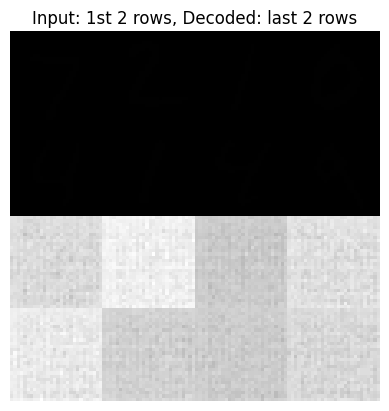

In [31]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming x_decoded has shape (10000, 112, 112, 1)
# Assuming x_test has shape (10000, 28, 28, 1)
# Assuming image_size is 28

# Resize x_decoded to match x_test dimensions before concatenation
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img
x_decoded_resized = np.zeros((x_decoded.shape[0], 28, 28, 1))
for i in range(x_decoded.shape[0]):
    img = array_to_img(x_decoded[i])
    img = img.resize((28, 28))
    x_decoded_resized[i] = img_to_array(img)

# Now you can concatenate
imgs = np.concatenate([x_test[:8], x_decoded_resized[:8]])
imgs = imgs.reshape((4, 4, image_size, image_size))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure()
plt.axis('off')
plt.title('Input: 1st 2 rows, Decoded: last 2 rows')
plt.imshow(imgs, interpolation='none', cmap='gray')
plt.savefig('input_and_decoded.png')
plt.show()